# Default CCT

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

class GPSABlock(layers.Layer):
    """
    Generalized Positional Self-Attention (GPSA) block.
    """
    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0., locality_strength=1.):
        super(GPSABlock, self).__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qk = layers.Dense(dim * 2)  # Query and Key
        self.v = layers.Dense(dim)       # Value
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)

        self.pos_proj = layers.Dense(num_heads)
        self.locality_strength = locality_strength
        self.gating_param = tf.Variable(tf.ones([num_heads]), trainable=True, name="gating_param")

        self.rel_indices = None  # Initialized during build

    def build(self, input_shape):
        num_patches = input_shape[1]  # Sequence length
        if self.rel_indices is None or self.rel_indices.shape[1] != num_patches:
            self.rel_indices = self._get_rel_indices(num_patches)

    def _get_rel_indices(self, num_patches):
        img_size = int(num_patches ** 0.5)  # Assumes square grid
        x_coords, y_coords = tf.range(img_size, dtype=tf.float32), tf.range(img_size, dtype=tf.float32)
        x_grid, y_grid = tf.meshgrid(x_coords, y_coords)
        x_grid_flat, y_grid_flat = tf.reshape(x_grid, [-1]), tf.reshape(y_grid, [-1])
        dx = tf.expand_dims(x_grid_flat, axis=1) - tf.expand_dims(x_grid_flat, axis=0)
        dy = tf.expand_dims(y_grid_flat, axis=1) - tf.expand_dims(y_grid_flat, axis=0)
        distances = tf.sqrt(tf.square(dx) + tf.square(dy))
        rel_indices = tf.stack([dx, dy, distances], axis=-1)
        rel_indices = tf.reshape(rel_indices, (1, num_patches, num_patches, 3))
        return rel_indices
        

def call(self, x):
    input_shape = tf.shape(x)
    batch_size = input_shape[0]  # Batch size
    num_patches = input_shape[1]  # Number of patches
    _ = input_shape[2]  # Feature dimension (not used directly)

    # Compute query, key, value
    qk = self.qk(x)
    qk = tf.reshape(qk, (batch_size, num_patches, 2, self.num_heads, self.head_dim))
    query, key = tf.transpose(qk[:, :, 0, :, :], [0, 2, 1, 3]), tf.transpose(qk[:, :, 1, :, :], [0, 2, 1, 3])
    value = tf.transpose(tf.reshape(self.v(x), (batch_size, num_patches, self.num_heads, self.head_dim)), [0, 2, 1, 3])

    # Positional and patch-based attention scores
    pos_score = tf.nn.softmax(self.pos_proj(self.rel_indices), axis=-1)
    patch_score = tf.nn.softmax(tf.matmul(query, key, transpose_b=True) * self.scale, axis=-1)

    # Gating mechanism
    gating = tf.nn.sigmoid(self.gating_param)[tf.newaxis, :, tf.newaxis, tf.newaxis]
    attn = (1. - gating) * patch_score + gating * pos_score
    attn = attn / tf.reduce_sum(attn, axis=-1, keepdims=True)
    attn = self.attn_drop(attn)

    # Apply attention to value
    x = tf.matmul(attn, value)
    x = tf.transpose(x, [0, 2, 1, 3])
    x = tf.reshape(x, (batch_size, num_patches, self.dim))

    # Projection and dropout
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


class MHSA(layers.Layer):
    """
    Multi-Head Self-Attention (MHSA) Layer with consistent output dimensions.
    """
    def __init__(self, projection_dim, num_heads):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.query_dense = layers.Dense(projection_dim)
        self.key_dense = layers.Dense(projection_dim)
        self.value_dense = layers.Dense(projection_dim)
        self.combine_heads = layers.Dense(projection_dim)  # Ensure output matches projection_dim

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        score = score / tf.sqrt(tf.cast(self.projection_dim // self.num_heads, tf.float32))
        weights = tf.nn.softmax(score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]  # Preserve sequence length

        query = self.split_heads(self.query_dense(inputs), batch_size)
        key = self.split_heads(self.key_dense(inputs), batch_size)
        value = self.split_heads(self.value_dense(inputs), batch_size)
        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, seq_length, self.projection_dim))
        output = self.combine_heads(concat_attention)
        return output


def mlp(inputs, hidden_units, dropout, projection_dim):
    """
    MLP block with consistent output dimension.
    """
    x = layers.Dense(hidden_units[0], activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden_units[1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(projection_dim)(x)
    return x

def Transformer_Encoder_with_Attention(L, embedded_patches, num_heads, projection_dim, transformer_units):
    for i in range(L):
        print(f"Input shape at Layer {i}: {embedded_patches.shape}")

        # Normalize input
        norm = layers.LayerNormalization(epsilon=1e-5)(embedded_patches)

        # GPSA block
        gpsa_output = GPSABlock(dim=projection_dim, num_heads=num_heads)(norm)
        print(f"GPSA output shape at Layer {i}: {gpsa_output.shape}")

        # MHSA block
        mhsa_output = MHSA(projection_dim, num_heads)(gpsa_output)
        print(f"MHSA output shape at Layer {i}: {mhsa_output.shape}")

        # Align dimensions for residual connection
        if mhsa_output.shape[-1] != projection_dim:
            mhsa_output = layers.Dense(projection_dim)(mhsa_output)  # Align dimensions to match projection_dim
        print(f"Aligned MHSA output shape at Layer {i}: {mhsa_output.shape}")

        # Residual connection
        skip1 = layers.Add()([mhsa_output, embedded_patches])
        print(f"Skip1 shape at Layer {i}: {skip1.shape}")

        # Normalize again
        norm2 = layers.LayerNormalization(epsilon=1e-5)(skip1)

        # Feed-forward network
        ffn = mlp(norm2, hidden_units=transformer_units, dropout=0.1, projection_dim=projection_dim)
        print(f"MLP output shape at Layer {i}: {ffn.shape}")

        # Second residual connection
        embedded_patches = layers.Add()([ffn, skip1])
        print(f"Output shape at Layer {i}: {embedded_patches.shape}")

    return embedded_patches
    
    
def CompactConvolutionalTransformer_with_Attention(image_size=224, num_classes=2, input_shape=(224, 224, 3),
                                                    projection_dim=128, num_heads=2, L=2, transformer_units=[128, 128]):
    """
    Compact Convolutional Transformer (CCT) with integrated GPSA and MHSA blocks.
    """
    inputs = layers.Input(shape=input_shape)
    conv_tokenizer = ConvolutionalTokenizer()
    embedded_patches = conv_tokenizer(inputs)
    pos_embed, seq_length = conv_tokenizer.pos_embeddings(image_size)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    embedded_patches += position_embeddings
    embedded_patches = Transformer_Encoder_with_Attention(L, embedded_patches, num_heads=num_heads,
                                                          projection_dim=projection_dim,
                                                          transformer_units=transformer_units)
    sequence_pooling = SeqPool(embedded_patches)
    output = layers.Dense(num_classes, activation='softmax')(sequence_pooling)
    model = keras.Model(inputs=inputs, outputs=output)
    return model
    
    
    
    
def SeqPool(trans_enco_out):
    """
    Sequence Pooling block.
    
    Args: 
        trans_enco_out: Takes in the Output of transformer encoder block 
    
    Returns:
        A 1xD output to be fed to final classifier
    """
    # Normalizing the output of transformer enocder layer
    normalized = layers.LayerNormalization(epsilon=1e-5)(trans_enco_out)
    # Adding a linear layer
    linear=layers.Dense(1)(normalized)
    # Applying Softmax to the linear layer
    soft = tf.nn.softmax(linear, axis=1)
    # Multiplying the softmax of linear layer with the normalized output of orignal output of the transformer encoder block
    mult = tf.matmul(soft, normalized, transpose_a=True)
    # Squeezing the dimensions
    seq_pool_output = tf.squeeze(mult, -2)

    return seq_pool_output
    
    
    
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

class ConvolutionalTokenizer(layers.Layer):
    """
    Creates Convolutional Tokens of images for feeding to Transformer Encoder.
    """
    def __init__(self, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2,
                 conv_layers=2, num_output_channels=[64, 128], **kwargs):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)
        
        # Creating a Sequential Keras Model for Tokenizing images
        self.conv_model = keras.Sequential()
        # Creating the required number of convolutional layers
        for i in range(conv_layers):
            # Adding a Conv2D layer with ReLU activation as suggested by authors
            self.conv_model.add(layers.Conv2D(num_output_channels[i], kernel_size, stride,
                                              padding="valid", use_bias=False, activation="relu",
                                              kernel_initializer="he_normal"))
            # Zero Padding
            self.conv_model.add(layers.ZeroPadding2D(padding))
            # Pooling over the image with 3x3 kernel, padding='same' and stride=2   
            self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))

    def call(self, images):
        # Pass RGB images through the convolutional model
        outputs = self.conv_model(images)
        # Flatten the output
        flattened = tf.reshape(outputs,
                               (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]))
        return flattened

    def pos_embeddings(self, image_size):
        # Ensure the input has 3 channels for RGB
        inp = tf.ones((1, image_size, image_size, 3))  # RGB shape
        out = self.call(inp)
        seq_len = tf.shape(out)[1]
        projection_dim = tf.shape(out)[-1]

        # Define the positional embedding layer
        embed_layer = layers.Embedding(input_dim=seq_len, output_dim=projection_dim)
        return embed_layer, seq_len



In [3]:
# Define Model Parameters
image_size = 224
n_classes = 2
batch_size = 32
learning_rate = 0.001
num_epochs = 100
projection_dim = 128
num_heads = 2
transformer_units = [256, 128]  # MLP layers in the Transformer
transformer_layers = 2  # Number of Transformer Encoder layers

# Instantiate the Compact Transformer Model with GPSA
cct = CompactConvolutionalTransformer_with_Attention(
    image_size=image_size,
    num_classes=n_classes,
    input_shape=(image_size, image_size, 3),
    projection_dim=projection_dim,
    num_heads=num_heads,
    L=transformer_layers,
    transformer_units=transformer_units,
)



Input shape at Layer 0: (None, 3136, 128)
GPSA output shape at Layer 0: (None, 3136, 128)
MHSA output shape at Layer 0: (None, 3136, 128)
Aligned MHSA output shape at Layer 0: (None, 3136, 128)
Skip1 shape at Layer 0: (None, 3136, 128)
MLP output shape at Layer 0: (None, 3136, 128)
Output shape at Layer 0: (None, 3136, 128)
Input shape at Layer 1: (None, 3136, 128)
GPSA output shape at Layer 1: (None, 3136, 128)
MHSA output shape at Layer 1: (None, 3136, 128)
Aligned MHSA output shape at Layer 1: (None, 3136, 128)
Skip1 shape at Layer 1: (None, 3136, 128)
MLP output shape at Layer 1: (None, 3136, 128)
Output shape at Layer 1: (None, 3136, 128)


In [4]:
from tensorflow.keras.models import load_model
weights_path = r'E:\Projects\Content-moderation\weights\compact_transformer_gpsa (1).hdf5'
# cct = CompactConvolutionalTransformer_with_Attention()
cct.load_weights(weights_path)



print("HDF5 model weights loaded successfully!")

HDF5 model weights loaded successfully!


# SpectralVision

In [5]:
import tensorflow as tf
class GhostModule(tf.keras.layers.Layer):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = int(oup // ratio)  # Ensure it's an integer
        new_channels = int(init_channels * (ratio - 1))

        self.primary_conv = tf.keras.Sequential([
            layers.Conv2D(init_channels, kernel_size, stride, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

        self.cheap_operation = tf.keras.Sequential([
            layers.DepthwiseConv2D(dw_size, 1, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

    def call(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = tf.concat([x1, x2], axis=-1)
        return out[:, :, :, :self.oup]

class TripletAttention(tf.keras.layers.Layer):
    def __init__(self, no_spatial=False, **kwargs):
        super(TripletAttention, self).__init__(**kwargs)
        self.no_spatial = no_spatial

    def channel_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 2, 1, 3]) 
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 2, 1, 3])  

    def height_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 3, 2, 1])  # Swap height and channels
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 3, 2, 1])  

    def spatial_attention(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

    def call(self, x):
        x_cw = self.channel_attention(x)
        x_hw = self.height_attention(x)
        x_sp = self.spatial_attention(x) if not self.no_spatial else 0

        # Combine attentions
        if not self.no_spatial:
            x = (x_cw + x_hw + x_sp) / 3.0
        else:
            x = (x_cw + x_hw) / 2.0
        return x



class NeighborhoodAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, num_heads=4, key_dim=None, attn_dropout=0.0, name=None):
        super().__init__(name=name)
        self.kernel_size = kernel_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

    def build(self, input_shape):
        channels = input_shape[-1]
        self.key_dim = self.key_dim or channels // self.num_heads
        self.qkv_layer = layers.Dense(self.num_heads * self.key_dim * 3)
        self.attn_dropout_layer = layers.Dropout(self.attn_dropout)
        self.output_layer = layers.Dense(channels)

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        qkv = self.qkv_layer(inputs)  # [batch, height, width, num_heads * key_dim * 3]
        qkv = tf.reshape(qkv, [-1, height * width, self.num_heads, 3 * self.key_dim])
        query, key, value = tf.split(qkv, 3, axis=-1)  # Split into Q, K, V
        query = tf.transpose(query, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        key = tf.transpose(key, [0, 2, 3, 1])      # [batch, num_heads, key_dim, height * width]
        attention_scores = tf.matmul(query, key) / tf.math.sqrt(float(self.key_dim))  # [batch, num_heads, height * width, height * width]
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_scores = self.attn_dropout_layer(attention_scores)
        value = tf.transpose(value, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.matmul(attention_scores, value)  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # [batch, height * width, num_heads, key_dim]
        attention_output = tf.reshape(attention_output, [batch_size, height, width, self.num_heads * self.key_dim])  # [batch, height, width, num_heads * key_dim]
        return self.output_layer(attention_output)
        
        


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_optimized_custom_cnn():
    input_layer = layers.Input(shape=(224, 224, 3))  # Correct usage of Input
    ghost1 = GhostModule(inp=3, oup=32, kernel_size=3)(input_layer)
    downsample = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ghost1)
    downsample_2 = layers.MaxPooling2D(pool_size=(2, 2))(downsample)
    nat = NeighborhoodAttention(kernel_size=3, num_heads=1, name="nat1")(downsample_2)  # Ensure NeighborhoodAttention is defined
    conv_layer_1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(nat)
    conv_layer_1 = layers.BatchNormalization()(conv_layer_1)
    global_avg_pool = layers.GlobalAveragePooling2D()(conv_layer_1)
    fc_layer_1 = layers.Dense(128, activation="relu")(global_avg_pool)
    fc_layer_1 = layers.BatchNormalization()(fc_layer_1)

    fc_layer_2 = layers.Dense(64, activation="relu")(fc_layer_1)
    fc_layer_2 = layers.BatchNormalization()(fc_layer_2)

    output_layer = layers.Dense(2, activation="softmax")(fc_layer_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Instantiate and summarize the model
optimized_custom_cnn_model = create_optimized_custom_cnn()
optimized_custom_cnn_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 ghost_module (GhostModule)  (None, 224, 224, 32)      704       
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 nat1 (NeighborhoodAttention  (None, 56, 56, 32)       4224      
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        1849

In [7]:
# Specify the path to your weights file
weights_path = r"E:\Projects\Content-moderation\weights\custom_cnn_model.hdf5"

# Load the weights into the model
optimized_custom_cnn_model.load_weights(weights_path)

# Verify the model has loaded the weights
print("Weights loaded successfully.")


Weights loaded successfully.


# ContiNet


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ContextBlock(nn.Module):
    def __init__(self, inplanes, ratio=1/16, pooling_type='att'):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
            nn.LayerNorm([self.planes, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
        )
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            nn.init.kaiming_normal_(self.conv_mask.weight, mode='fan_in')
            self.conv_mask.inited = True

        nn.init.constant_(self.channel_add_conv[-1].weight, 0)
        nn.init.constant_(self.channel_add_conv[-1].bias, 0)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x).view(batch, 1, height * width)
            context_mask = self.softmax(context_mask).unsqueeze(-1)
            context = torch.matmul(input_x, context_mask).view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)
        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        channel_add_term = self.channel_add_conv(context)
        out = x + channel_add_term
        return out

class CustomModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomModel, self).__init__()
        self.conv1 = ConvBlock(in_channels, 8, 7, pad=3)
        self.conv2 = ConvBlock(8, 32, 7, pad=3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.context1 = ContextBlock(32, ratio=1/8)
        
        self.conv3 = ConvBlock(32, 64, kernel_size=3, pad=1)
        self.context2 = ContextBlock(64, ratio=1/8)
        
        self.conv4 = ConvBlock(64, 128, kernel_size=3, pad=1)
        self.context3 = ContextBlock(128, ratio=1/8)
        
        self.conv5 = ConvBlock(128, 256, kernel_size=3, pad=1)
        self.context4 = ContextBlock(256, ratio=1/8)
        
        # self.conv6 = ConvBlock(256, 512, kernel_size=3, pad=1)
        # self.context5 = ContextBlock(512, ratio=1/8)
        
        self.conv7 = ConvBlock(256, 512, kernel_size=3, pad=1)
        self.context6 = ContextBlock(512, ratio=1/8)
        
        self.conv8 = ConvBlock(512, 1024, kernel_size=3, pad=1)
        self.context7 = ContextBlock(1024, ratio=1/8)
        
        self.max_pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.bn2d = nn.BatchNorm2d(1024)
        self.cbam_block1 = CBAM(1024)  # Moved CBAM here
        self.fc1 = nn.Linear(1024 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.context1(x)
        x = self.max_pool1(x)

        x = self.conv3(x)
        x = self.context2(x)
        # x = self.max_pool2(x)

        x = self.conv4(x)
        x = self.context3(x)
        x = self.max_pool2(x)

        x = self.conv5(x)
        x = self.context4(x)
        x = self.max_pool2(x)

        # x = self.conv6(x)
        # x = self.context5(x)
        # x = self.max_pool2(x)
        
        x = self.conv7(x)
        x = self.context6(x)
        x = self.max_pool2(x)
        
        x = self.conv8(x)
        x = self.context7(x)
        x = self.max_pool2(x)
        x = self.cbam_block1(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# model = CustomModel()
# random_image = torch.randn(1, 3, 224, 224)
# # print(model)
# output = model(random_image)
# print(output.shape)


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

# Define paths
data_dir = '../out'
batch_size = 32

# Define the image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets from each subfolder
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

subset_ratio = 0.5

# Calculate the subset lengths
train_len = int(len(train_dataset) * subset_ratio)
val_len = int(len(val_dataset) * subset_ratio)
test_len = int(len(test_dataset) * subset_ratio)

# Create subsets using random_split
gen = torch.Generator().manual_seed(42)  # For reproducibility
train_subset, _ = random_split(train_dataset, [train_len, len(train_dataset) - train_len], generator=gen)
val_subset, _ = random_split(val_dataset, [val_len, len(val_dataset) - val_len], generator=gen)
test_subset, _ = random_split(test_dataset, [test_len, len(test_dataset) - test_len], generator=gen)

# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
model = CustomModel(in_channels=3, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


e:\Anaconda\envs\tf211\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
model = CustomModel(in_channels=3, num_classes=2)
model.load_state_dict(torch.load('E:\Projects\Content-moderation\weights\custom_modelbest1.pth',map_location=torch.device('cpu')))
print(model)

C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_22308\228009825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_modelbest1.

CustomModel(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (context1): ContextBlock(
    (conv_mask): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=2)
    (channel_add_conv): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): LayerNorm((4, 1, 1), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv3): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3

# Soft Voting Ensemble

## SpectralVision

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the test data directory
test_data_path = r"E:\Projects\Content-moderation\out\test"

# Define image parameters
image_size = (224, 224)  # Should match the model input size
batch_size = 32          # Batch size for loading images
class_names = ["Neutral", "NSFW"]  # Replace with your actual class labels

# Calculate the 50% data size
total_samples = sum([len(files) for _, _, files in os.walk(test_data_path) if files])
half_samples = total_samples // 2

# Load the test data with subset configuration
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.5)  # Split into halves
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Do not shuffle to match predictions with filenames
    subset='validation'  # Use 50% of the data
)

# Get true labels for the subset
true_labels = test_generator.classes


# Evaluate
# print(classification_report(true_labels, predicted_classes, target_names=class_names))


Found 2773 images belonging to 2 classes.


In [61]:
# # Predict using the model
# cnn_predictions = optimized_custom_cnn_model.predict(test_generator)
# predicted_classes = np.argmax(cnn_predictions, axis=1)


In [7]:
val_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # Do not shuffle to match predictions with filenames
    subset='training'  # Use 50% of the data
)

Found 2774 images belonging to 2 classes.


In [14]:
cnn_predictions2 = optimized_custom_cnn_model.predict(val_generator)
predicted_classes2 = np.argmax(cnn_predictions2, axis=1)

87/87 [==============================] - 167s 2s/step


In [62]:
# report = classification_report(true_labels, np.argmax(cnn_predictions, axis=1), target_names=class_names)
# print("Classification Report:\n", report)

In [51]:
report = classification_report(val_generator.classes, np.argmax(cnn_predictions2, axis=1), target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.91      0.96      0.94      1676
        NSFW       0.93      0.86      0.89      1098

    accuracy                           0.92      2774
   macro avg       0.92      0.91      0.92      2774
weighted avg       0.92      0.92      0.92      2774



## CCT predictions

In [63]:

# cct_predictions = cct.predict(test_generator)
# predicted_classes = np.argmax(cct_predictions, axis=1)


In [9]:

cct_predictions2 = cct.predict(val_generator)
predicted_classes2 = np.argmax(cct_predictions2, axis=1)


87/87 [==============================] - 761s 9s/step


In [54]:
# report = classification_report(true_labels, np.argmax(cct_predictions, axis=1), target_names=class_names)
# print("Classification Report:\n", report)

In [10]:
report = classification_report(val_generator.classes, np.argmax(cct_predictions2, axis=1), target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.92      0.93      0.92      1676
        NSFW       0.90      0.87      0.88      1098

    accuracy                           0.91      2774
   macro avg       0.91      0.90      0.90      2774
weighted avg       0.91      0.91      0.91      2774



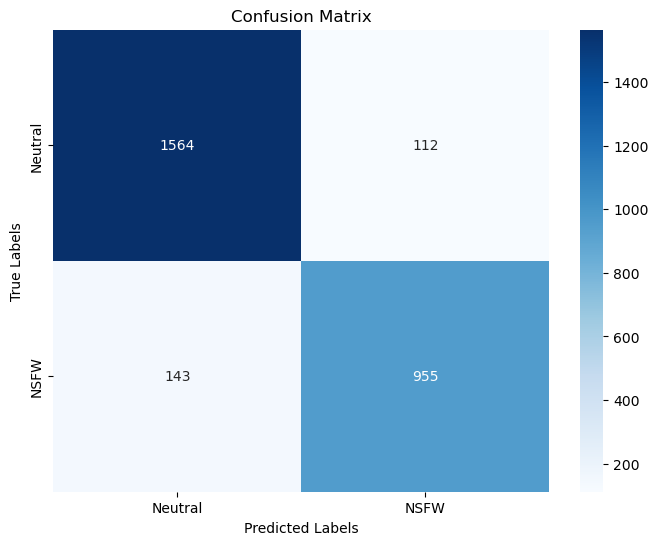

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, np.argmax(cct_predictions2, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## ContiNet

In [16]:
subset_filenames = val_generator.filenames
full_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
]))
filename_to_index = {os.path.relpath(full_dataset.samples[i][0], start=os.path.join(data_dir, 'test')): i for i in range(len(full_dataset))}

# Get indices corresponding to the TensorFlow subset
subset_indices = [filename_to_index[fname] for fname in subset_filenames]

# Create a PyTorch Subset using the same indices
test_subset = Subset(full_dataset, subset_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [68]:
print(subset_filenames)

['NSFW\\blood24_cid_0_fr_5917_ts_00-03-17-233_jpg.rf.2039190c0012342f391910585af51c6a.jpg', 'NSFW\\blood24_cid_0_fr_6240_ts_00-03-28-000_jpg.rf.062bb3e9fdb0d52aa1b9d41442a192be.jpg', 'NSFW\\blood24_cid_0_fr_635_ts_00-00-21-166_jpg.rf.659cab2f41e2f934caac5d5cec3382e7.jpg', 'NSFW\\blood24_cid_0_fr_6374_ts_00-03-32-466_jpg.rf.3ff3f3ef16bb0468567d8b7a442ab604.jpg', 'NSFW\\blood24_cid_0_fr_6377_ts_00-03-32-566_jpg.rf.9573a50ebbe8fe3e3201c36569893cfb.jpg', 'NSFW\\blood24_cid_0_fr_6429_ts_00-03-34-300_jpg.rf.9f4d5a5d1fb79c59d8bda150adff7000.jpg', 'NSFW\\blood24_cid_0_fr_6491_ts_00-03-36-366_jpg.rf.ccdb52c57175992b5fc714bc95b86680.jpg', 'NSFW\\blood24_cid_0_fr_6624_ts_00-03-40-800_jpg.rf.e6e9cc72a2ee0771d046c1c4a0650904.jpg', 'NSFW\\blood24_cid_0_fr_6626_ts_00-03-40-866_jpg.rf.83b0a920fed117dbac2c2857fd74db29.jpg', 'NSFW\\blood24_cid_0_fr_7799_ts_00-04-19-966_jpg.rf.2c6c015eda198f3024113470e25f9ccb.jpg', 'NSFW\\blood24_cid_0_fr_8377_ts_00-04-39-233_jpg.rf.7b48e31c04ab5cece2db359a3d071ccb.jpg',

In [17]:

torch_predictions = []
all_preds = []
all_labels = []
# Generate predictions
with torch.no_grad():
    for images, labels in test_loader:  # Labels aren't needed for inference
        images = images.to('cpu')  # Move images to the same device as the model
        labels = labels.to('cpu')  # Move images to the same device as the model
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
        torch_predictions.extend(probs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())  

# Convert predictions to NumPy array
torch_predictions = np.array(torch_predictions)

In [18]:
model.eval()
device='cpu'
torch_predictions = []
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
        _, preds = torch.max(outputs, 1)
        torch_predictions.extend(probs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
torch_predictions = np.array(torch_predictions)

In [46]:
report = classification_report(val_generator.classes, all_preds, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.85      0.48      0.61      1676
        NSFW       0.52      0.87      0.65      1098

    accuracy                           0.63      2774
   macro avg       0.69      0.67      0.63      2774
weighted avg       0.72      0.63      0.63      2774



In [21]:
import os
import numpy as np
import tensorflow as tf
import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score





# Perform soft voting
average_predictions = (cct_predictions2 + cnn_predictions2 + torch_predictions) / 3
final_predictions = np.argmax(average_predictions, axis=1)


# Generate classification report
class_names = ["Neutral", "NSFW"]  # Replace with your actual class labels
report = classification_report(val_generator.classes, final_predictions, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Neutral       0.91      0.98      0.94      1676
        NSFW       0.97      0.85      0.90      1098

    accuracy                           0.93      2774
   macro avg       0.94      0.91      0.92      2774
weighted avg       0.93      0.93      0.93      2774



<Figure size 800x600 with 0 Axes>

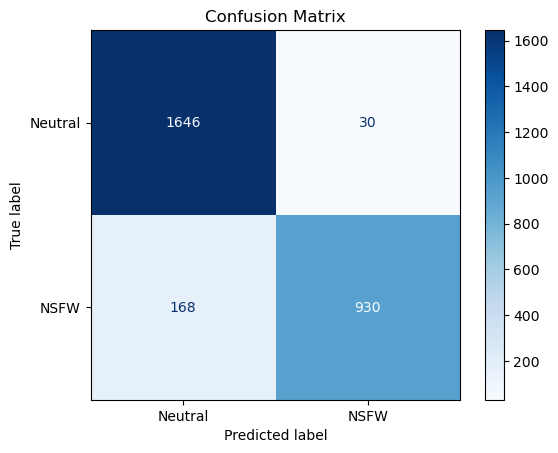

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, final_predictions)

# Plot: Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


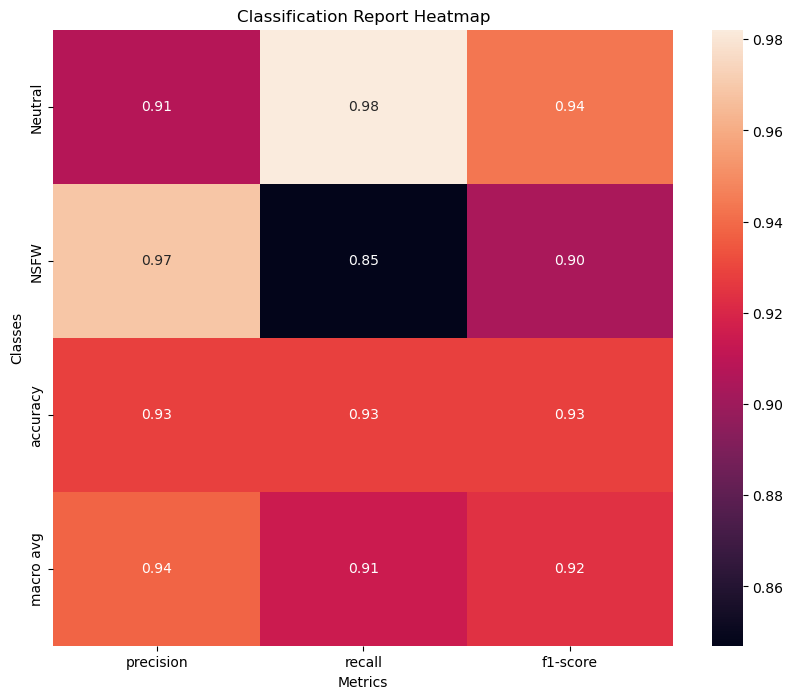

In [24]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Generate the classification report
report = classification_report(
    val_generator.classes, 
    final_predictions, 
    target_names=class_names, 
    output_dict=True
)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot: Heatmap of the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(
    report_df.iloc[:-1, :-1],  # Exclude the "support" row and "accuracy" column
    annot=True, 
    fmt=".2f", 
)
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()
